# Implementing the Transformer Network in PyTorch



In this notebook, we will build a Transformer network in PyTorch to do two sequence-to-sequence tasks (copy and paste; machine translation). First, we will implement all the modules in a Transformer network, including Multi-Headed Attention Network, Position-Wise Feed-Forward Networks, Embeddings and Softmax, Positional Encoding, etc. Second, we will combine them and build the final encoder-decoder model. At last, we will evaluate the Transformer model on a simple copy-paste task and a German-English machine translation task. The Colab link is https://colab.research.google.com/drive/1ZxmTZeHW2G4EYQdZg6wgt-1BNPT-DIKk and the slides are sent by email.

## The Transformer model

Let's recall the Transformer model discussed in the previous lecture "The Transformer Network for NLP".

![](https://drive.google.com/uc?id=1PpiyJfOAqGYG5KeJN79iUzL5SLkdcT9w)


## Requirements and Installation

Before we get started, let's import the packages we'll be using.



In [0]:
# Uncomment and run it if you are not using Colab. Colab is discussed in the previous lecture "0B_Coding_Environments.ipynb".
# !pip install torch numpy matplotlib spacy torchtext seaborn 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## Multi-Headed Attention Network

<figure>
<center>
<img src='https://drive.google.com/uc?id=1dAjWR_mhZfEiIsUB28T6txzN6rMXcYlf' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

### Scaled Dot-Product Attention

#### The input of the “Scaled Dot-Product Attention” consists of queries and keys of dimension $n \times d_k$, and values of dimension $n \times d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.


<figure>
<center>
<img src='https://drive.google.com/uc?id=1eTqwXpLZL-fNWbxK37oETvs-aeo59RRR'/>
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

#### The reason that we scale the dot products by $\frac{1}{\sqrt{d_k}}$ is:

#### If the value of $d_k$ is large, we scale the dot products by $\frac{1}{\sqrt{d_k}}$ to avoid the large magnitude of the dot products. For example, assume the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$, their dot product $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$ has mean $0$ and variance $d_k$.


In [0]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    # Scaled Dot Product Attention
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    # Set score values to minus infinity if masked
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

#### Example:

In [4]:
Q = torch.randn(2,3)
K = torch.randn(2,3)
V = torch.randn(2,5)

output, p_attn = attention(Q, K, V)
print(output.size(), p_attn.size())
print(p_attn)
print(torch.sum(p_attn, dim=-1))

torch.Size([2, 5]) torch.Size([2, 2])
tensor([[0.7175, 0.2825],
        [0.7132, 0.2868]])
tensor([1., 1.])



### Multi-Headed Attention

The model uses multi-headed attention to jointly attend to information from different representation subspaces at different positions, while with a single attention head the model cannot.

The parameter matrices of the four Linear layers are $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$. In the codes below, we employ the attention heads $h=8$, $d_{\text{model}}=512$, and $d_k=d_v=d_{\text{model}}/h=64$.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1Vw3BguL7Mvc4Ddqw1uvIBhN52GPKgpJL' width="450" height="500" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>


In [0]:
def clones(module,N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implement the figure."
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)      

In [7]:
# Example
multihead = MultiHeadedAttention(4,100)
query = key = value = torch.randn(1,2,100)
z = multihead(query, key, value)
print(z.size(), query.size())

torch.Size([1, 2, 100]) torch.Size([1, 2, 100])


## Position-Wise Feed-Forward Networks

The position-wise feed-forward network is a two-layer fully connected network with a ReLU activation in between. The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has the dimensionality $d_{ff}=2048$.

<figure>
<center>
<img src='https://drive.google.com/uc?id=13SC5hJ9vKchWy4lM4HTHpz0DNvyCwUAs' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implement the FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
      super(PositionwiseFeedForward, self).__init__()
      self.w_1 = nn.Linear(d_model, d_ff)
      self.w_2 = nn.Linear(d_ff, d_model)
      self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
      return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [9]:
# Example
pff = PositionwiseFeedForward(4,8)

x = torch.randn(2,4)
z = pff(x)
print(x.size(), z.size())

torch.Size([2, 4]) torch.Size([2, 4])


## Add&Norm and Skip-Connect

We employ a residual connection around each of the two sub-layers (Multi-Headed Attention, FeedForward Network), followed by a layer normalization which can be represented as $\mathrm{LayerNorm}(x + Dropout(\mathrm{Sublayer}(x)))$.

To make the add operation viable, all sub-layers in the model, as well as the embedding layers, produce outputs of the dimension $d_{\text{model}}=512$.


<figure>
<center>
<img src='https://drive.google.com/uc?id=1YBkh8m-iA8UL2MzBE6jr3kQkjtIWddbO' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>


In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
      super(SublayerConnection, self).__init__()
      self.norm = nn.LayerNorm(size)
      self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Embeddings and Softmax
The learned linear transformation (or learned embeddings) converts the input/output tokens to the $d_{\text{model}}$-dimentional vectors. And we use the embeddings and softmax to convert the output of the decoder to predicted next-token probabilities. 


<figure>
<center>
<img src='https://drive.google.com/uc?id=1llvh0JQXzqBXNEP3LyK25YEzjs_ZZYVZ' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
      super(Embeddings, self).__init__()
      self.lut = nn.Embedding(vocab, d_model)
      self.d_model = d_model

    def forward(self, x):
      return self.lut(x) * math.sqrt(self.d_model)

In [0]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # The pre-softmax linear transformation
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Positional Encoding

The information from the order of the sequential tokens is injected to the model via positional encoding. The positional embeddings are added at the bottoms of the encoder and decoder stacks. In order to add them to the word embeddings, we choose the same dimension $d_{\text{model}}$ as the word embeddings.

In the codes below, we use sine and cosine functions of different frequencies.

$    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$

The $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

What's more, we apply dropout with a rate of $P_{drop}=0.1$ to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ayaDTqxzmyG44UWjU-rMJOtpx7gNsNAh' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2)*-(math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self, x):
        x = x + Variable(self.pe[:,:x.size(1)], requires_grad=False)
        return self.dropout(x)

#### Example:

For different positions (x-axis) and different dimensions (sine waves), the positional encodings (y-axis) are different.

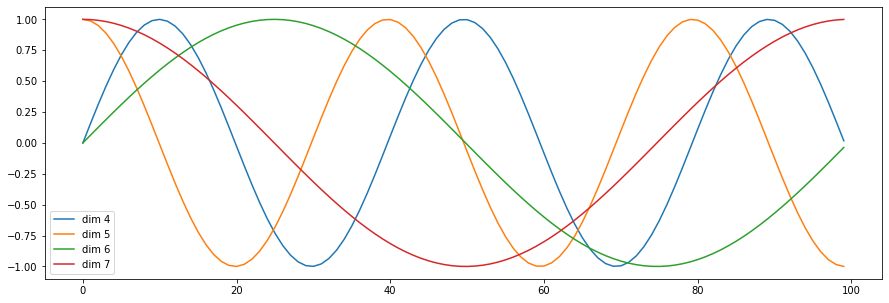

In [14]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## Transformer Model Architecture

The sequence-to-sequence task typically utlizes an **Encoder-Decoder** structure. The encoder maps an input sequence of symbol representations $(x_1, …, x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, …, z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,…,y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

## Encoder and Decoder Stacks

### Encoder
The encoder is composed of a stack of $N=6$ identical layers. Each layer is a  multi-headed self-attention network followed by a position-wise fully connected feed-forward network.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1hKSpRIPvPLxBEl3PanUl9owhTqf4yAFo' width="300" height="500" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

In [0]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers. Each layer in the decoder consists of three sub-layers, multi-headed self-attention networks, a multi-headed attention network over the output of the encoder stack, and a position-wise fully connected feed-forward network. 

<figure>
<center>
<img src='https://drive.google.com/uc?id=1jX9m6mK_DBv7hsOkcHkHYDJiUq4VtR_U' width="450" height="600" />
<!---<figcaption>Image Caption</figcaption>--->
</center>
</figure>

In [0]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [0]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Masking is used in the self-attention sub-layer in the decoder stack to prevent from attending to subsequent positions. It ensures the predictions for position $i$ depend only on the words on the left side of word at position $i$.

In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0    

#####Example: 
We show an example below to demonstrate the position each tgt word (row) is allowed to look at (column) under the masking mechanism. During the training, words are blocked for attending to future words.

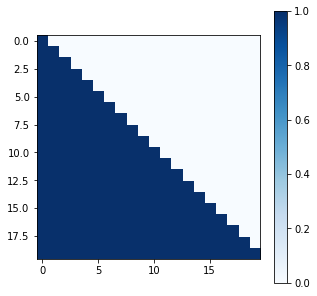

In [21]:
plt.figure(figsize=(5,5))
pos = plt.imshow(subsequent_mask(20)[0]*1, cmap='Blues') # True -> 1, False -> 0
plt.colorbar(pos)

## Make a Full Model

We define a function that takes in hyperparameters and generates a full Encoder-Decoder Transformer Network.


In [0]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Training
We will describe the training for the Transformer model.

### Batches and Masking

First, we define a batch ojbect. It holds the source (src) and target (trg) sentences for training, and constructs the masks.

In [0]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### Training Loop

Next we create a training loop to update the model.


In [0]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### Optimizer
We use the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$. We define a optimizer wrapper to vary the learning rate over the course of training.  The learning rate is increased linearly for the first $steps_{warmup}=4000$ training steps, and decreased thereafter proportionally to the inverse square root of the step number. 


In [0]:
class OptWrapper:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._step = 0

        self.lr_lambda = lambda step: self.factor * (self.model_size ** (-0.5) *
                    min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.lr_lambda(self._step)
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self.optimizer.step()

####Example:

The curve of the learning rate scheduler is as follows.

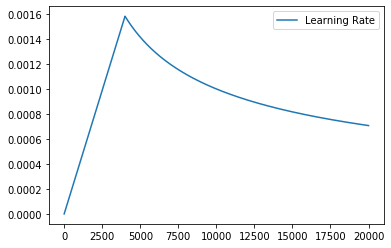

In [26]:
# Three settings of the lrate hyperparameters.
lr_factor = 2
lr_model_size = 400
lr_warmup = 4000
lr_lambda = lambda step: lr_factor * (lr_model_size ** (-0.5) *
                    min((step+1) ** (-0.5), (step+1) * lr_warmup ** (-1.5)))

plt.plot(np.arange(1, 20000), [lr_lambda(i) for i in range(1, 20000)])
plt.legend(["Learning Rate"])

### Regularization

#### Label Smoothing
During the training, we employ label smoothing of value $\epsilon_{ls}=0.1$. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score. We implement label smoothing using the Kullback–Leibler divergence loss. 

In [0]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## Example - 1 (Synthetic Example)

Let's test the model on a simple copy-paste task, by generating back the same symbols given a random set of input symbols from a small vocabulary.

### Data

In [0]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy-paste task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

### Loss Computation

In [0]:
class LossCompute:
    "A loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            # clear the variables (set to 0) in the optimizer.
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

### Greedy Decoding

In [30]:
# Train the simple copy-paste task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = OptWrapper(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              LossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    LossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.252573 Tokens per Sec: 418.581146
Epoch Step: 1 Loss: 1.903271 Tokens per Sec: 717.822144
tensor(1.9534)
Epoch Step: 1 Loss: 1.954832 Tokens per Sec: 562.516602
Epoch Step: 1 Loss: 1.649048 Tokens per Sec: 716.893799
tensor(1.6425)
Epoch Step: 1 Loss: 1.763388 Tokens per Sec: 563.846802
Epoch Step: 1 Loss: 1.367883 Tokens per Sec: 718.164917
tensor(1.3313)
Epoch Step: 1 Loss: 1.923001 Tokens per Sec: 536.253174
Epoch Step: 1 Loss: 1.105387 Tokens per Sec: 715.071777
tensor(1.0902)
Epoch Step: 1 Loss: 1.499996 Tokens per Sec: 540.585144
Epoch Step: 1 Loss: 0.721465 Tokens per Sec: 730.944641
tensor(0.7371)
Epoch Step: 1 Loss: 1.032160 Tokens per Sec: 562.703857
Epoch Step: 1 Loss: 0.468373 Tokens per Sec: 724.492676
tensor(0.5072)
Epoch Step: 1 Loss: 0.550630 Tokens per Sec: 558.326965
Epoch Step: 1 Loss: 0.441794 Tokens per Sec: 723.157715
tensor(0.3968)
Epoch Step: 1 Loss: 1.191086 Tokens per Sec: 545.023865
Epoch Step: 1 Loss: 0.387948 Tokens per Sec: 721.345581

In [31]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    "This code predicts a translation using greedy decoding for simplicity."
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


## Example - 2 (Assignment: Real World Example)

Let's test the model on a real-world IWSLT German-English Translation task. 

In [32]:
# Download the data.
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 11.1MB 601kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.1.0-cp36-none-any.whl size=11073065 sha256=dbef9c1255bbc8cfe2746a3f96fd57a026e285cfbce2d7081302c25b7a6b47a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-g13h_1pt/wheels/b4/8b/5e/d2ce5d2756ca95de22f50f68299708009a4aafda2aea79c4e4
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


### Data Loading

Load and tokenize the dataset using torchtext and spacy.

In [0]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)


In [34]:
# To save the time, we only consider a small subset of the corpus with length (8, 10]. 
MAX_LEN = 10
MIN_LEN = 8
train, val, test = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TGT), 
    filter_pred=lambda x: MIN_LEN < len(vars(x)['src']) <= MAX_LEN and 
            MIN_LEN < len(vars(x)['trg']) <= MAX_LEN)


de-en.tgz:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:00<00:00, 26.2MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-en/train.tags.de-en.de


In [35]:
print(len([x for x in train.src]))
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print(len(SRC.vocab))
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)
print(len(TGT.vocab))

7230
3694
3386


### Data Iterators

It generates source and target data at each iteration.

In [0]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [0]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

We create the model, criterion, and data iterators.

In [0]:
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=1)
    #model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    #criterion.cuda()
    BATCH_SIZE = 100
    train_iter = MyIterator(train, batch_size=BATCH_SIZE,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)

### Training the System

In [0]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [40]:
# You could stop it manually and run the next code cell.
if True:
    model_opt = OptWrapper(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model, 
                  LossCompute(model.generator, criterion, opt=model_opt))
        model.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model, 
                          LossCompute(model.generator, criterion, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

Epoch Step: 1 Loss: 7.158245 Tokens per Sec: 325.679016
Epoch Step: 51 Loss: 5.921081 Tokens per Sec: 423.697998
Epoch Step: 101 Loss: 5.196033 Tokens per Sec: 420.296631
Epoch Step: 151 Loss: 4.235659 Tokens per Sec: 418.736755
Epoch Step: 201 Loss: 4.551528 Tokens per Sec: 413.069611
Epoch Step: 251 Loss: 4.086952 Tokens per Sec: 425.697601
Epoch Step: 301 Loss: 3.590018 Tokens per Sec: 433.185242
Epoch Step: 351 Loss: 4.507064 Tokens per Sec: 457.248474
Epoch Step: 401 Loss: 4.160588 Tokens per Sec: 449.624359
Epoch Step: 451 Loss: 3.455229 Tokens per Sec: 430.544067
Epoch Step: 501 Loss: 3.622535 Tokens per Sec: 432.358063
Epoch Step: 551 Loss: 3.440207 Tokens per Sec: 455.170959
Epoch Step: 601 Loss: 3.569884 Tokens per Sec: 451.598236
Epoch Step: 651 Loss: 2.485881 Tokens per Sec: 438.401337
Epoch Step: 701 Loss: 3.704904 Tokens per Sec: 450.612701
Epoch Step: 751 Loss: 3.005895 Tokens per Sec: 455.473328
Epoch Step: 801 Loss: 0.896699 Tokens per Sec: 443.155304
Epoch Step: 851 L

KeyboardInterrupt: ignored

We evaluate the trained model by simply translating the first sentence in the validation set. 

In [41]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

Translation:	This is my <unk> . I is your ? 
Target:	That is my <unk> . What 's yours ? 


## References

[1] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems. 2017.

[2] Klein, Guillaume, et al. "Opennmt: Open-source toolkit for neural machine translation." arXiv preprint arXiv:1701.02810 (2017).

[3] http://jalammar.github.io/illustrated-transformer/